In [235]:
import pymc3 as pm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import arviz as az
import requests
from datetime import datetime as dt

Dados de isolamento

In [221]:
url  = 'https://public.tableau.com/vizql/w/IsolamentoSocial/v/DADOS/vudcsv/sessions/E4BECCEE3449429CBD254C9D99330682-0:0/views/1292535119418963567_2497449162794898547?underlying_table_id=Migrated%20Data&underlying_table_caption=Full%20Data'
#url  = 'https://public.tableau.com/vizql/w/IsolamentoSocial/v/DADOS/vudcsv/sessions/9DDB779699C4466B808B761E723874E4-0:0/views/1292535119418963567_2497449162794898547?summary=true'
dfiso = pd.read_csv(url, sep = ';')

HTTPError: HTTP Error 410: Gone

In [231]:
dfiso.columns = ['municipio', 'uf', 'data', 'iso']
dfiso.iso = dfiso.iso.apply(lambda l: pd.to_numeric(l[:2])/100)
dfiso.data = dfiso.data.apply(lambda l: pd.to_datetime(l, format = '%d/%m/%y'))

TypeError: 'float' object is not subscriptable

In [244]:
dfisouf = dfiso.drop('municipio', axis = 1).groupby(['uf', 'data']).mean().reset_index()

In [245]:
dfisouf = dfisouf.sort_values('data')
dfisouf = dfisouf.set_index('data')

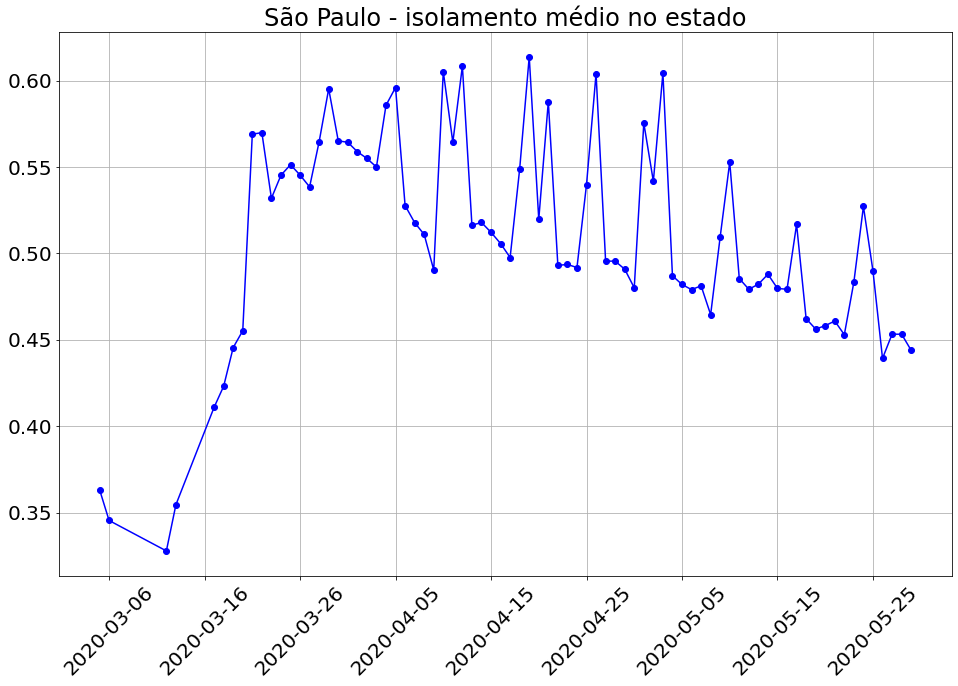

In [246]:
fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dfisouf.iso, 'bo-')
axs = plt.axes()
axs.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation = 45)
plt.title("São Paulo - isolamento médio no estado", fontsize = 24)
plt.grid(True)
plt.show()

Dados COVID

In [236]:
import requests
from io import StringIO

url = 'https://brasil.io/dataset/covid19/caso?format=csv'
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0"}
req = requests.get(url, headers=headers)
data = StringIO(req.text)

dfcov = pd.read_csv(data)
dfcov.date = pd.to_datetime(dfcov.date, format = '%Y-%m-%d')
dfcov.date = dfcov.date.apply(lambda d: dt.date(d))
dfuf = dfcov.loc[(dfcov.place_type == 'state')]
dfuf = dfuf.sort_values(by = ['state', 'date'])
dfmun = dfcov.loc[dfcov.city == 'São Paulo'].copy()
dfmun = dfmun.sort_values(by = ['date'])

In [237]:
def reindex_by_date(df):
    dates = pd.date_range(dfcov.date.min(), dfcov.date.max())
    return df.reindex(dates).bfill().ffill()

dfuf = dfuf.set_index('date').groupby('state').apply(reindex_by_date).reset_index(0, drop=True)
dfuf = dfuf.reset_index().rename({'index' :'date'}, axis = 1)

dfmun = dfmun.set_index('date').groupby('state').apply(reindex_by_date).reset_index(0, drop=True)
dfmun = dfmun.reset_index().rename({'index' :'date'}, axis = 1)

In [238]:
dfuf['dif'] = dfuf.reset_index().groupby('state').confirmed.diff(periods = 1).fillna(0)
dfmun['dif'] = dfmun.reset_index().groupby('state').confirmed.diff(periods = 1).fillna(0)

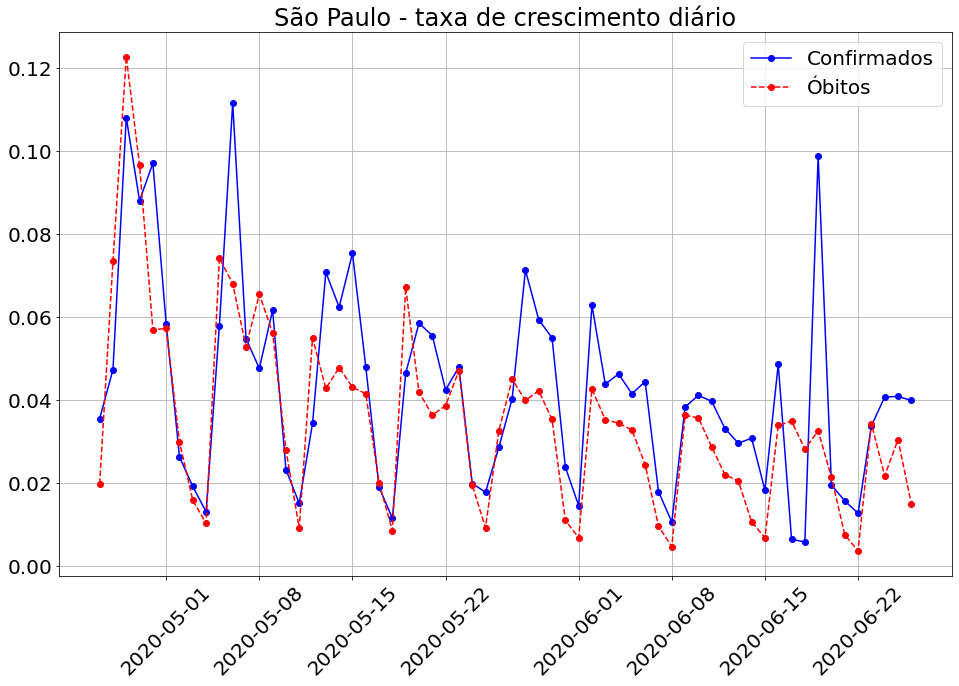

In [239]:
dfsp = dfuf.loc[dfuf.state == 'SP'].copy()

dfsp = dfsp.set_index('date')
#dfsp.loc['2020-04-02', 'confirmed'] = 3506
#dfsp.loc['2020-04-02', 'deaths'] = 208
dfsp['growth'] = dfsp.confirmed.pct_change()
dfsp['growthd'] = dfsp.deaths.pct_change()

dftmp = dfsp.loc[(dfsp.index > '2020-04-25')]# & (dfsp.index < '2020-06-01')]
#dfsp = dfsp.loc[ (dfsp.index <= '2020-04-16')]

fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dftmp.growth, 'bo-', label = 'Confirmados')
plt.plot(dftmp.growthd, 'ro--', label = 'Óbitos')
plt.xticks(rotation = 45)
plt.title("São Paulo - taxa de crescimento diário", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)

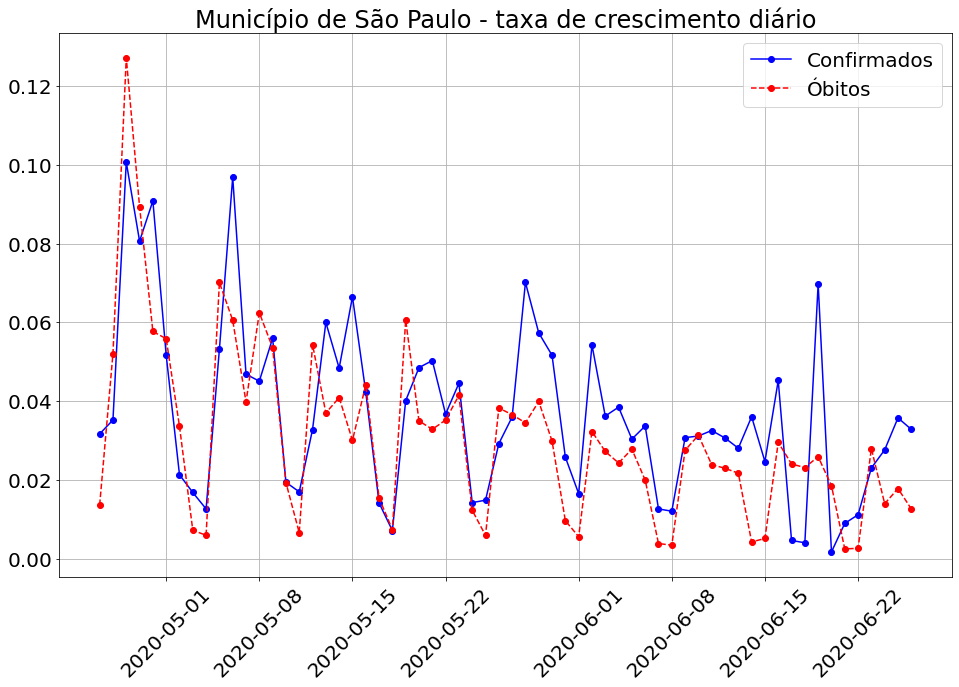

In [240]:
dfmun = dfmun.set_index('date')

dfmun['growth'] = dfmun.confirmed.pct_change()
dfmun['growthd'] = dfmun.deaths.pct_change()

dftmp = dfmun.loc[(dfmun.index > '2020-04-25')]# & (dfsp.index < '2020-06-01')]
#dfsp = dfsp.loc[ (dfsp.index <= '2020-04-16')]

fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dftmp.growth, 'bo-', label = 'Confirmados')
plt.plot(dftmp.growthd, 'ro--', label = 'Óbitos')
plt.xticks(rotation = 45)
plt.title("Município de São Paulo - taxa de crescimento diário", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)

In [233]:
# Convertendo pra doubling time
dfsp['doubling'] = np.log(2) / np.log(1+dfsp['growth'])
dfsp['doublingd'] = np.log(2) / np.log(1+dfsp['growthd'])

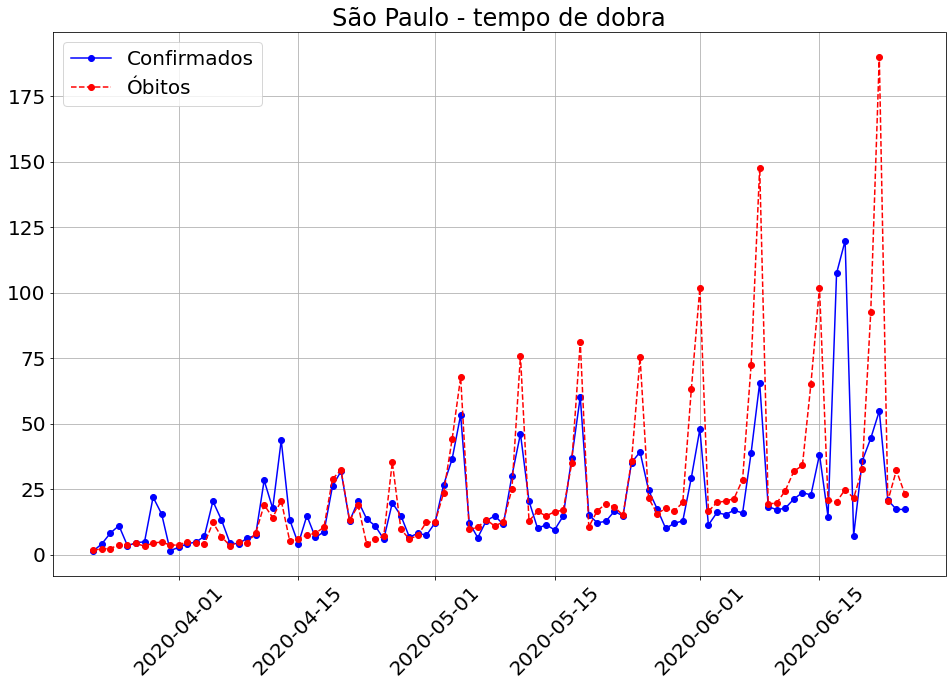

In [234]:
dftmp = dfsp.loc[(dfsp.index > '2020-03-21')]# & (dfsp.index <= '2020-04-19')]

fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dftmp.doubling, 'bo-', label = 'Confirmados')
plt.plot(dftmp.doublingd, 'ro--', label = 'Óbitos')
plt.xticks(rotation = 45)
plt.title("São Paulo - tempo de dobra", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)

Extraindo tendência da taxa de crescimento

In [193]:
dfall = dfsp#.merge(dfisouf, left_index = True, right_index = True)
dfall = dfall[(dfall.index > pd.to_datetime('2020-04-25')) & (dfall.index < pd.to_datetime('2020-06-01'))]

In [194]:
dfall['day'] = np.arange(0, dfall.shape[0])

from scipy.stats import linregress

mod = linregress(dfall.day, dfall.growthd)
dfall['trend'] = mod.intercept + mod.slope * dfall.day

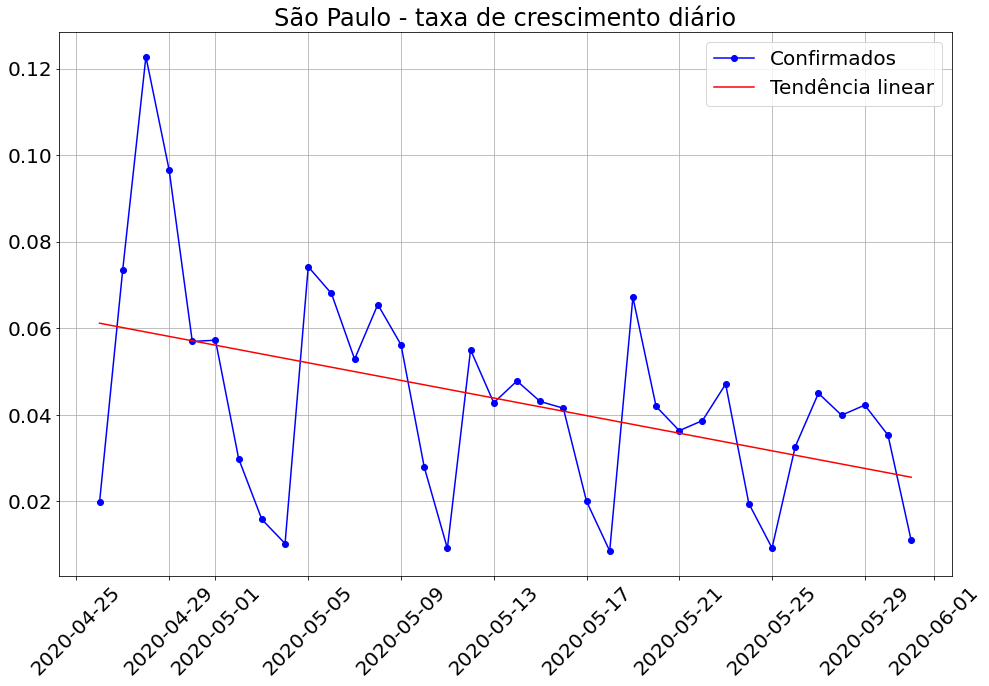

In [195]:
fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dfall.growthd, 'bo-', label = 'Confirmados')
plt.plot(dfall.trend, 'r-', label = 'Tendência linear')
plt.xticks(rotation = 45)
plt.title("São Paulo - taxa de crescimento diário", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)

In [196]:
dfall['growth2'] = dfall['growth'] - dfall.trend

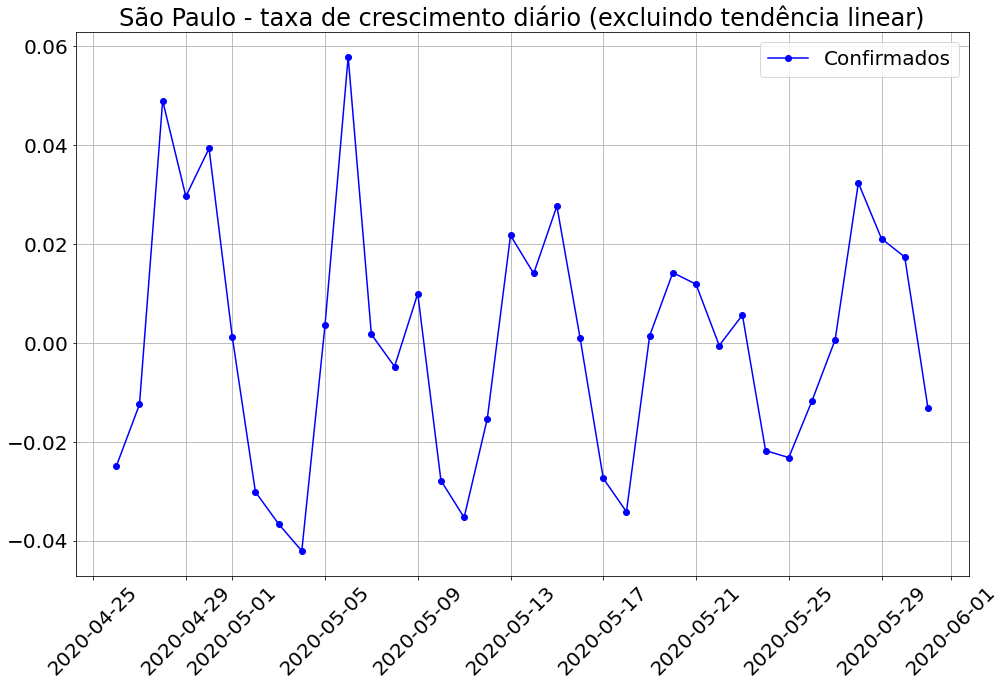

In [168]:
fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dfall.growth2, 'bo-', label = 'Confirmados')
plt.xticks(rotation = 45)
plt.title("São Paulo - taxa de crescimento diário (excluindo tendência linear)", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)

SARIMAX pra série sem tendênca

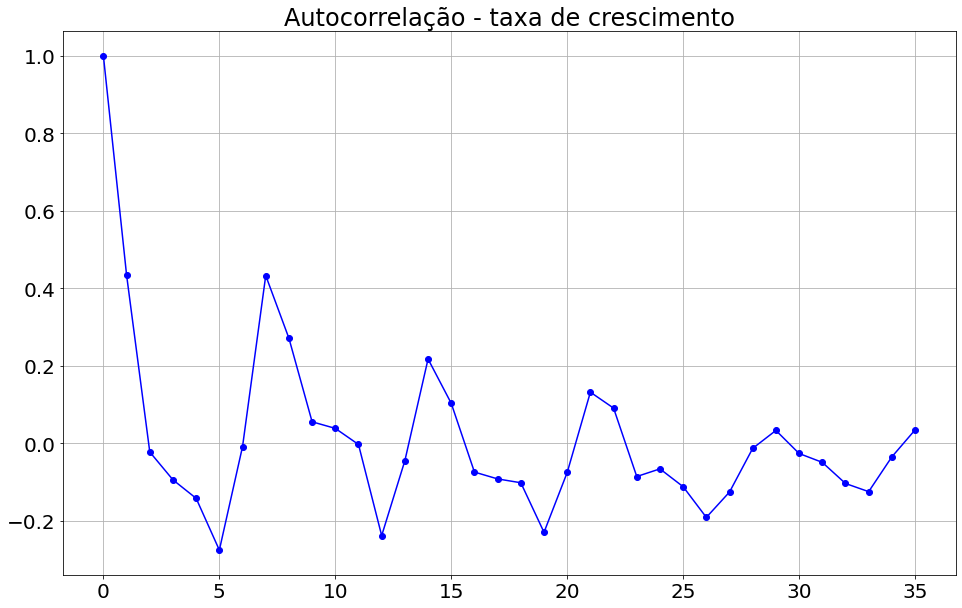

In [197]:
from statsmodels.tsa.stattools import acf

fig = plt.figure(figsize = (16, 10))
plt.plot(acf(dfall.growthd), 'bo-', label = 'Casos')
plt.title("Autocorrelação - taxa de crescimento")
plt.grid(True)

## Modelo ARIMA

In [184]:
# Tirando tendência
import statsmodels.api as sm

In [185]:
# No máximo lag 2
p = d = q = range(0, 2)

# Combinações
import itertools
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [186]:
y = dfall.growthd

import warnings
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{} - BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:-174.2930162135055 - BIC:-172.34177249492407
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:-193.95801217548978 - BIC:-190.34468719594915
ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:-239.35693093678904 - BIC:-237.5502684470187
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:-233.97774898080365 - BIC:-230.7025766613509
ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:-269.3863222603577 - BIC:-265.7290394673795
ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:-261.91433541224734 - BIC:-256.4943479429364
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:-239.91069158972397 - BIC:-236.58356829746467
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:-235.10988769007287 - BIC:-230.1971292108937
ARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:-211.63858307036008 - BIC:-207.77493180491143
ARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:-213.22991446201868 - BIC:-207.8773455602639
ARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:-266.6207678997223 - BIC:-263.0523886318858
ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:-228.51014002677528 - BIC:-223.6773862888426
ARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:-275.048050163409

In [198]:
y = dfall.growthd
param = (1,0,0)
param_seasonal = (0,1,1,7)
mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

In [199]:
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5571      0.169      3.301      0.001       0.226       0.888
ma.S.L7       -2.8869      1.363     -2.118      0.034      -5.558      -0.215
sigma2      2.175e-05   2.43e-05      0.894      0.371   -2.59e-05    6.94e-05


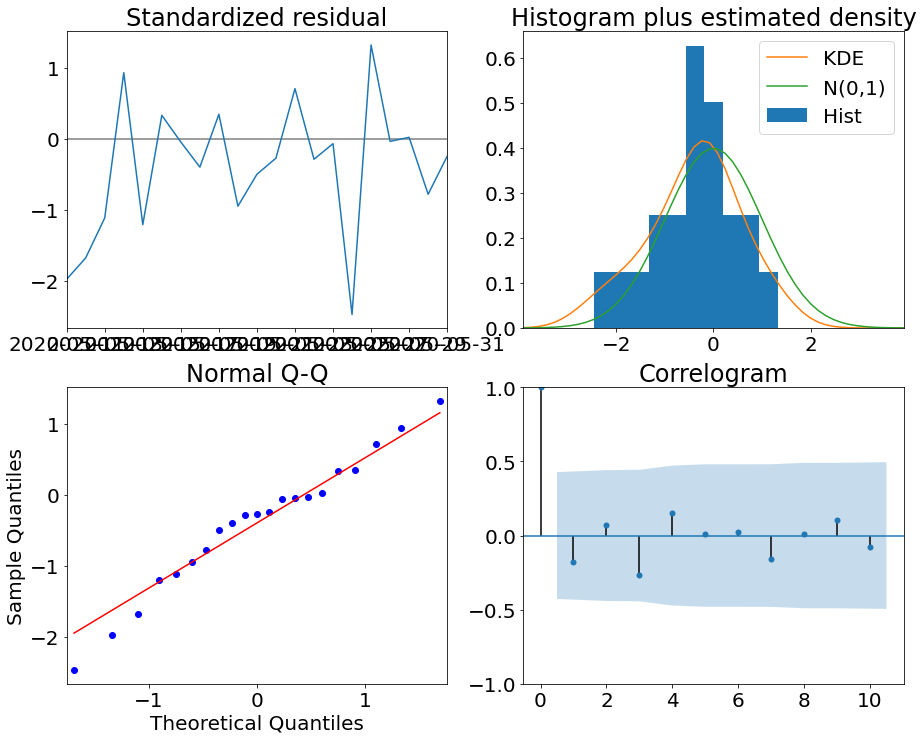

In [200]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [201]:
pred = results.get_prediction(start=pd.to_datetime('2020-06-01'), end = pd.to_datetime('2020-06-30'), dynamic=False)
pred_ci = pred.conf_int()

In [202]:
y = dfsp.loc[(dfsp.index > pd.to_datetime('2020-04-25')), 'growthd']

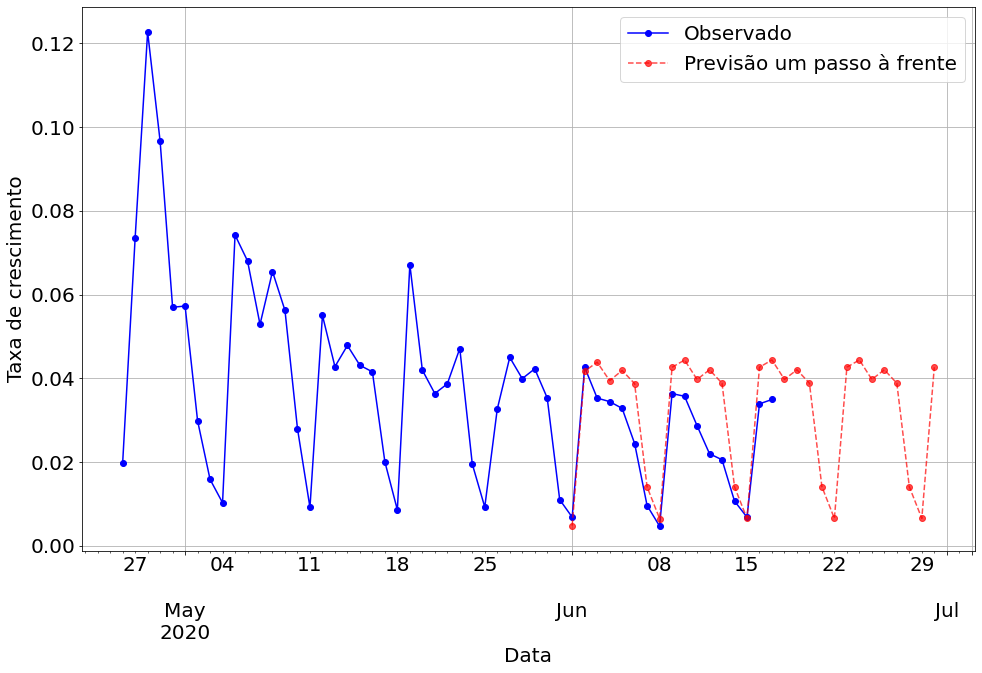

In [203]:
ax = y.plot(label='Observado', figsize = (16, 10), style = 'bo-')
pred.predicted_mean.plot(ax=ax, label='Previsão um passo à frente', alpha=.7, style = 'ro--')

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)#

ax.set_xlabel('Data')
ax.set_ylabel('Taxa de crescimento')
plt.legend()
plt.grid(True)

plt.show()

Isolamento x Crescimento

In [325]:
dfall['difiso'] = dfall.iso.pct_change()
dfall['difgrowth'] = dfall.growth.pct_change()
dfall['difgrowth2'] = dfall.growth2.pct_change()

AttributeError: 'DataFrame' object has no attribute 'growth2'

In [257]:
dfall = dfall[dfall.index > pd.to_datetime('2020-04-01')]

In [323]:
correl = []
for lag in range(1, 25):
    c = np.corrcoef(dfall.difiso[:-lag], dfall.difgrowth2[lag:])[0,1]
    print("Lag: {}, corr = {}".format(lag, c))
    correl.append(c)

#lag = 16
#plt.plot(dfall.iso[:-lag], dfall.growth[lag:], 'o')
#plt.grid(True)

fig = plt.figure(figsize = (16, 10))
plt.bar(range(1, 25), correl)
plt.title("Correlação isolamento social x taxa de crescimento")
plt.xlabel("Lag")
plt.ylabel("Correlação linear")
plt.grid(True)

AttributeError: 'DataFrame' object has no attribute 'difgrowth2'

Brasil

In [111]:
dftotal = dfuf.groupby('date').agg({'confirmed' : 'sum', 'deaths' : 'sum'}).reset_index()
dftotal = dftotal.sort_values('date', ascending = True)
dftotal = dftotal.set_index('date')

dftotal['growth'] = dftotal.confirmed.pct_change()
dftotal['growthd'] = dftotal.deaths.pct_change()

dftotal['newcases'] = dftotal.confirmed.diff(1)
dftotal['newdeaths'] = dftotal.deaths.diff(1)

dftotal['doubling'] = np.log(2) / np.log(1+dftotal['growth'])
dftotal['doublingd'] = np.log(2) / np.log(1+dftotal['growthd'])

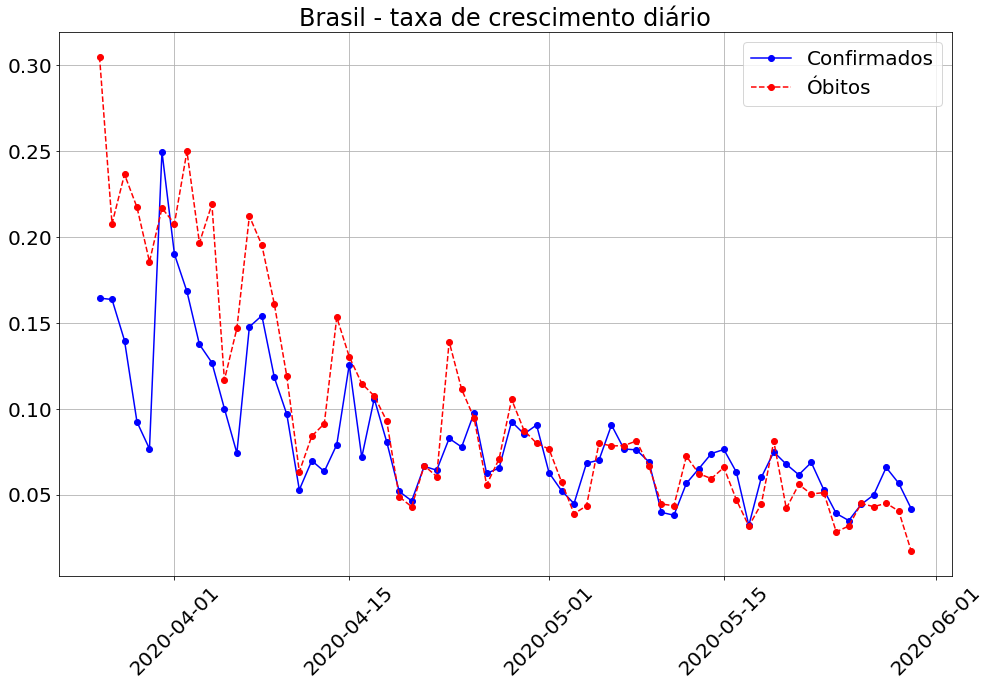

In [112]:
dftmp = dftotal.loc[(dftotal.index > '2020-03-25')]# & (dftotal.index <= '2020-05-04')]
#dfsp = dfsp.loc[ (dfsp.index <= '2020-04-16')]

fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dftmp.growth, 'bo-', label = 'Confirmados')
plt.plot(dftmp.growthd, 'ro--', label = 'Óbitos')
plt.xticks(rotation = 45)
plt.title("Brasil - taxa de crescimento diário", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)


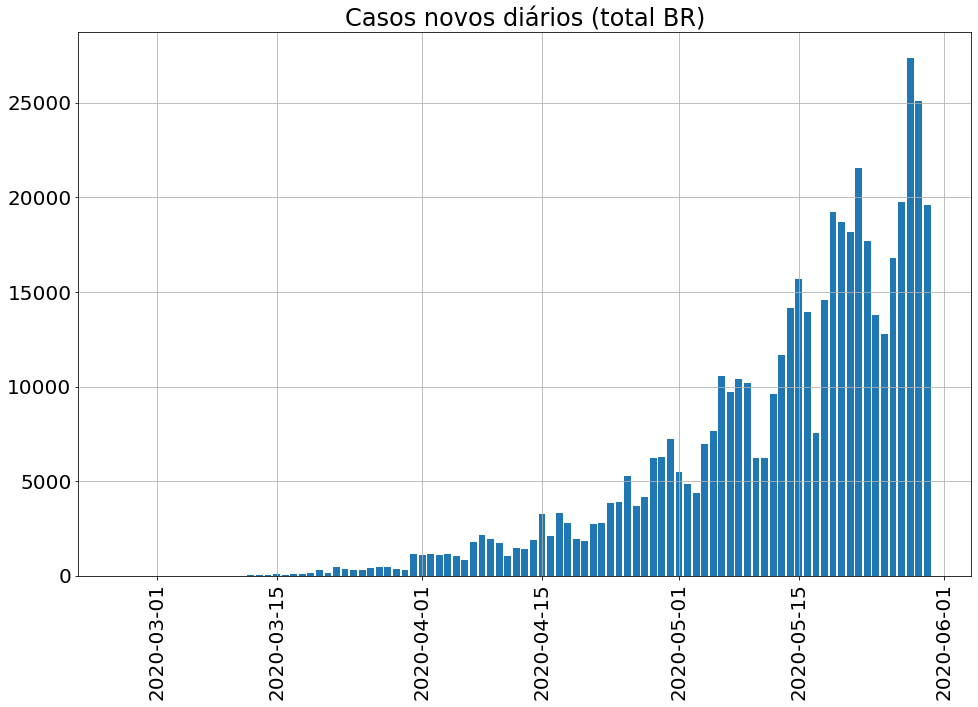

In [113]:
fig = plt.figure(figsize = (16, 10))

plt.bar(x = dftotal.index, height = dftotal.confirmed.diff(periods = 1))
plt.grid(True)
plt.xticks(rotation = 90)
plt.title("Casos novos diários (total BR)")
plt.show()

# Modelo por município

In [49]:
# Lendo lat long
dfgeo = pd.read_csv('municipios.csv')

In [76]:
dfmun = dfcov[(dfcov.place_type == 'city')]

In [77]:
dfmun = dfmun.loc[(~dfmun.city_ibge_code.isna())]

In [78]:
dfmun['city_ibge_code'] = dfmun.city_ibge_code.apply(lambda l: int(l))

In [79]:
dfmun = dfmun.merge(dfgeo[['codigo_ibge', 'latitude', 'longitude']], left_on = 'city_ibge_code', right_on = 'codigo_ibge', how = 'left')

In [84]:
from geopy import distance

In [102]:
from itertools import combinations
from tqdm import tqdm

i = 0
dist = []
for c in tqdm(combinations(dfmun.city_ibge_code.unique(), 2)):
    lat1, long1 = dfmun.loc[(dfmun.city_ibge_code == c[0]), ['latitude', 'longitude']].values[0]
    lat2, long2 = dfmun.loc[(dfmun.city_ibge_code == c[1]), ['latitude', 'longitude']].values[0]
    dist.append([c[0], c[1], distance.distance((lat1, long1), (lat2, long2))])
    

20503it [02:42, 127.76it/s]


In [103]:
dfdist = pd.DataFrame({'cod1' : [c[0] for c in dist], 'cod2' : [c[1] for c in dist], 'd' : [c[2] for c in dist]})
dfdist.to_csv('dist.csv', index = False)

In [104]:
dfdist

,cod1,cod2,d
0,1200401,2704302,3518.945021266715 km
1,1200401,2707503,3395.3005902876666 km
2,1200401,1302603,1148.3828643372065 km
3,1200401,1303403,1470.8928061489853 km
4,1200401,2903201,2504.993617485891 km
5,1200401,2904605,2883.7088016905755 km
6,1200401,2905701,3232.3746994815347 km
7,1200401,2906204,2854.555313420211 km
8,1200401,2908507,3182.91814783917 km
9,1200401,2908606,3307.5798684496062 km
